In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pylab import *
from itertools import combinations

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

## Пример графа с тремя вершинами

In [2]:
# Прокликивать каждый раз с создания графа

In [3]:
# Создание графа
Battle = nx.Graph()

# Создание вершин
Battle.add_node('Вершина 1', lamda_1 = 1.5, lamda_2 = 1.6, p_1 = 0.5, p_2 = 0.5, 
                N_10 = 100, N_20 = 100, casualties_lvl_1 = 0.3, casualties_lvl_2 = 0.3, was_retreat = False)

Battle.add_node('Вершина 2', lamda_1 = 1.5, lamda_2 = 1.6, p_1 = 0.5, p_2 = 0.5, 
                N_10 = 100, N_20 = 100, casualties_lvl_1 = 0.2, casualties_lvl_2 = 0.2, was_retreat = False)

Battle.add_node('Вершина 3', lamda_1 = 1.5, lamda_2 = 1.6, p_1 = 0.5, p_2 = 0.5, 
                N_10 = 100, N_20 = 100, casualties_lvl_1 = 0.1, casualties_lvl_2 = 0.1, was_retreat = False)

# Создание ребер
Battle.add_edge('Вершина 1', 'Вершина 2', weight=10)  
Battle.add_edge('Вершина 2', 'Вершина 3', weight=5)
Battle.add_edge('Вершина 1', 'Вершина 3', weight=7)  


for node in Battle.nodes():
    Battle.nodes[node]['N_1'] = Battle.nodes[node]['N_10']
    Battle.nodes[node]['N_2'] = Battle.nodes[node]['N_20']
    
    Battle.nodes[node]['N_for_retreat_1'] = Battle.nodes[node]['N_10'] * Battle.nodes[node]['casualties_lvl_1']
    Battle.nodes[node]['N_for_retreat_2'] = Battle.nodes[node]['N_20'] * Battle.nodes[node]['casualties_lvl_2']
    
    Battle.nodes[node]['a_1'] = Battle.nodes[node]['lamda_1'] * Battle.nodes[node]['p_1']
    Battle.nodes[node]['a_2'] = Battle.nodes[node]['lamda_2'] * Battle.nodes[node]['p_2']

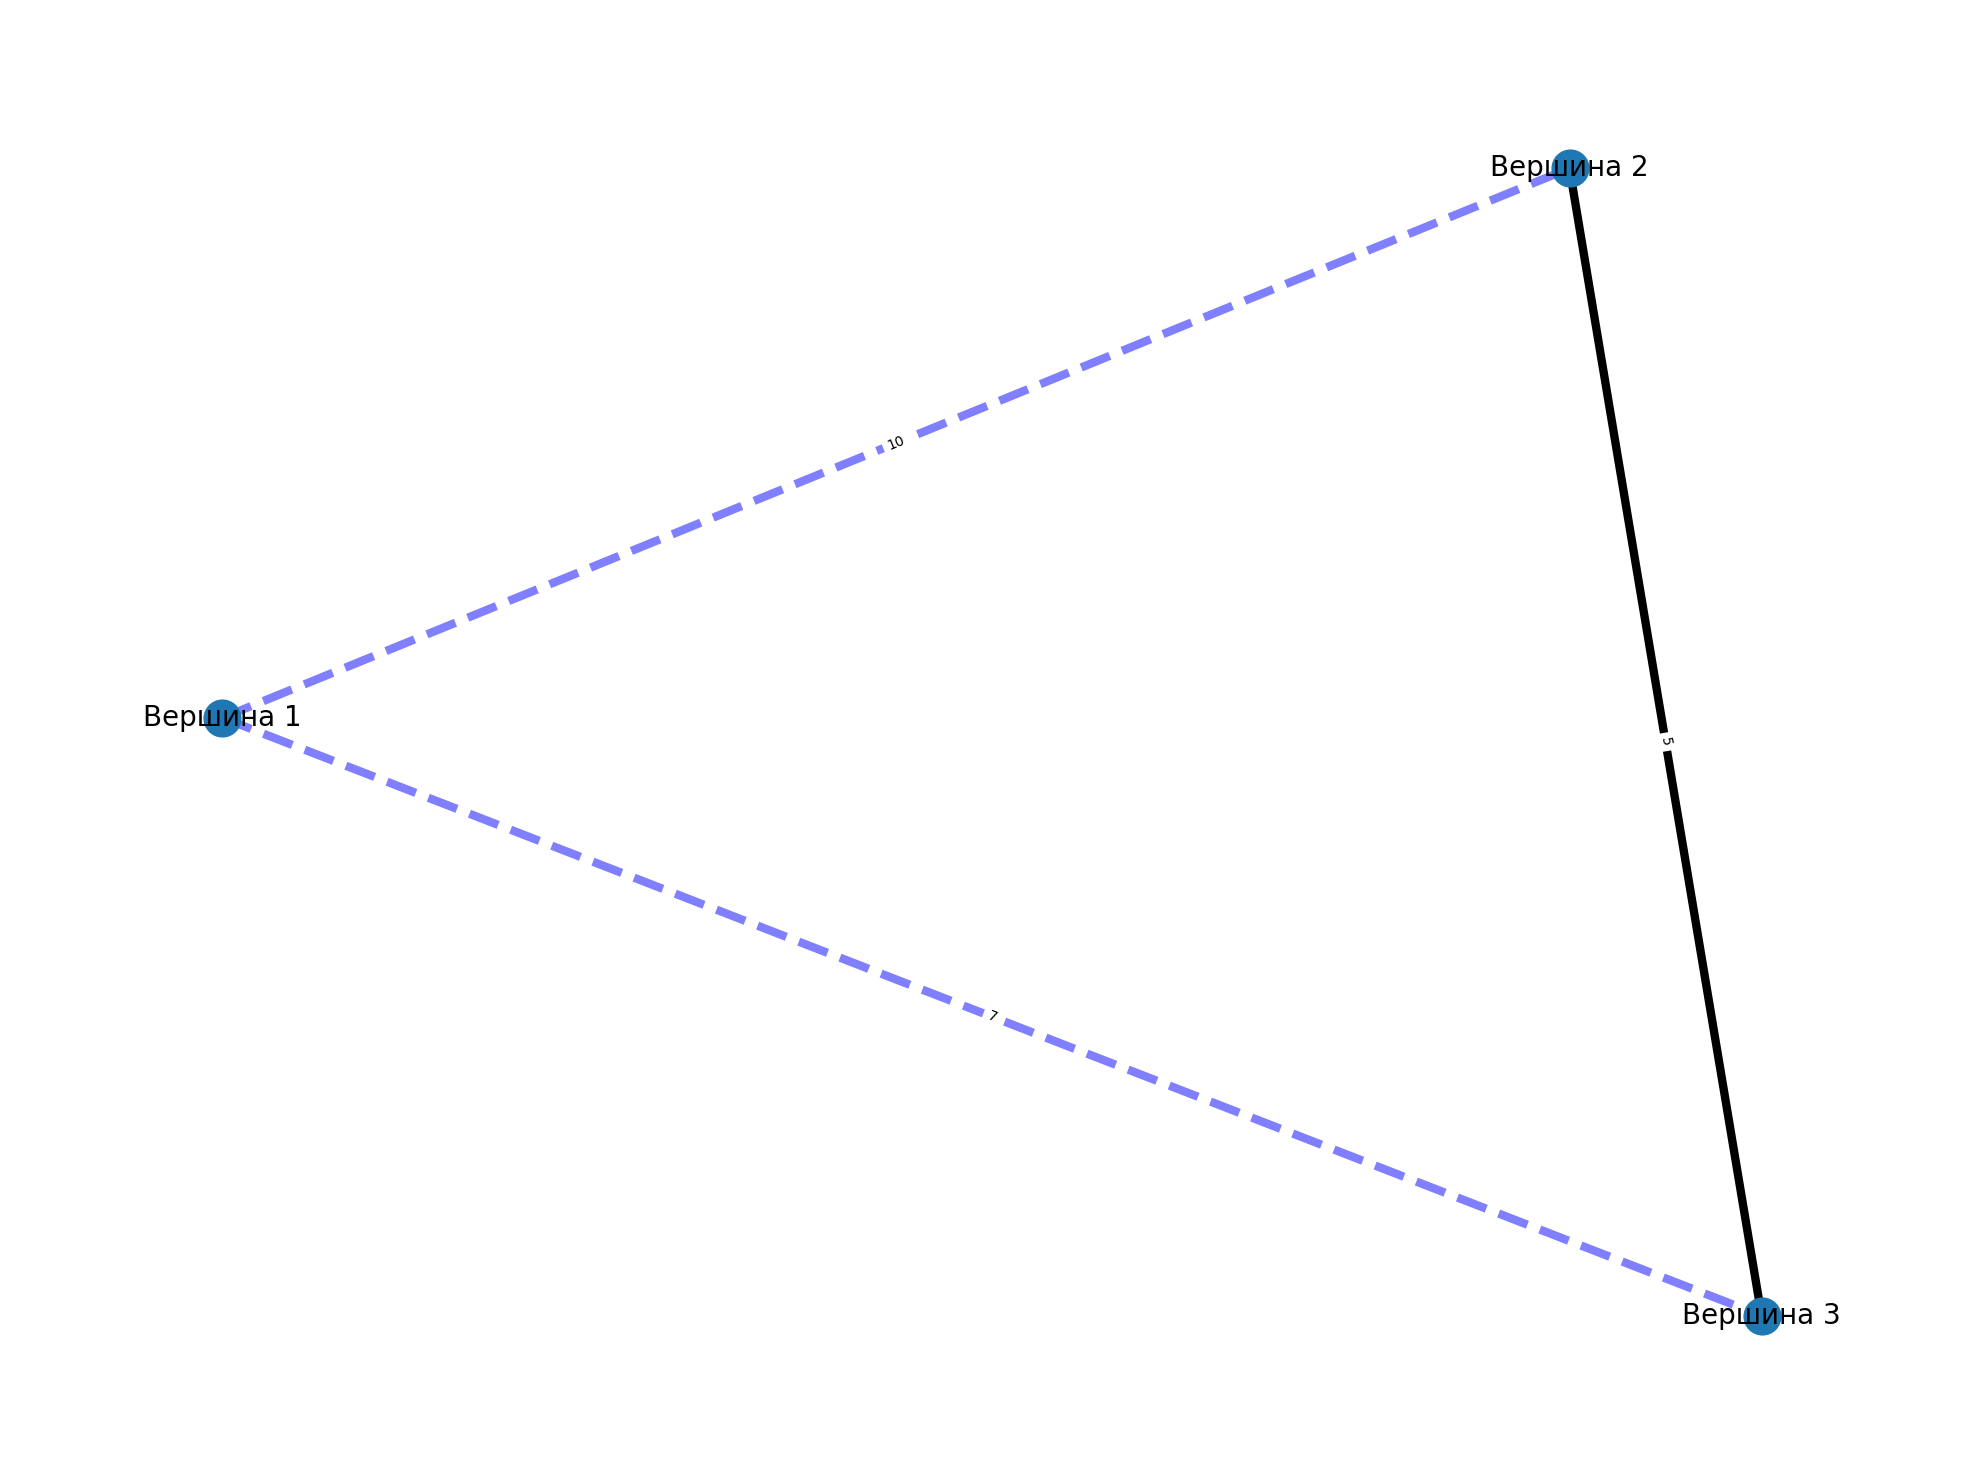

In [4]:
# Визуализация графа
plt.figure(figsize=(20,15))
elarge = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] <= 5]
esmall = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] > 5]

pos = nx.spring_layout(Battle, seed=7)

# nodes
nx.draw_networkx_nodes(Battle, pos, node_size=700)

# edges
nx.draw_networkx_edges(Battle, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    Battle, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(Battle, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(Battle, "weight")
nx.draw_networkx_edge_labels(Battle, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
t_of_simulation = 10
dt = 1e-2

tau = 0

for node in Battle.nodes():
    Battle.nodes[node]['history_N_1'] = [Battle.nodes[node]['N_1']]
    Battle.nodes[node]['history_N_2'] = [Battle.nodes[node]['N_2']]
    
t_arr = np.array([tau])

while (tau <= t_of_simulation) and (sum(list(nx.get_node_attributes(Battle, 'N_1').values())) > 0) and (sum(list(nx.get_node_attributes(Battle, 'N_2').values())) > 0):
    tau += dt
    tau = round(tau,2)
    for node in Battle.nodes():
        # функция для подброса подкреплений
        if Battle.nodes[node]['N_1'] == 0 and Battle.nodes[node]['was_retreat'] == False:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_2'] += Battle.nodes[node]['N_2'] 
                Battle.nodes[node]['a_2'] = (Battle.nodes[node]['a_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['a_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                Battle.nodes[node]['N_for_retreat_2'] = (Battle.nodes[node]['N_for_retreat_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['N_for_retreat_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                Battle.nodes[node]['N_2'] = 0
                Battle.nodes[node]['was_retreat'] = True
                list_of_reinforces.append([tau, node, closest_node, 'Сторона 2'])
        
        if Battle.nodes[node]['N_2'] == 0 and Battle.nodes[node]['was_retreat'] == False:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_1'] += Battle.nodes[node]['N_1']
                Battle.nodes[node]['a_1'] = (Battle.nodes[node]['a_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['a_1']*Battle.nodes[closest_node]['N_1'])/(Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
                Battle.nodes[node]['N_for_retreat_1'] = (Battle.nodes[node]['N_for_retreat_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['N_for_retreat_1']*Battle.nodes[closest_node]['N_1'])/(Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
                Battle.nodes[node]['N_1'] = 0
                Battle.nodes[node]['was_retreat'] = True
                list_of_reinforces.append([tau, node, closest_node, 'Сторона 1'])
        
        # Изменение численности войск
        dN_1 = -Battle.nodes[node]['a_2'] * Battle.nodes[node]['N_2'] * Battle.nodes[node]['N_1']/Battle.nodes[node]['N_10'] * dt
        dN_2 = -Battle.nodes[node]['a_1'] * Battle.nodes[node]['N_1'] * Battle.nodes[node]['N_2']/Battle.nodes[node]['N_20'] * dt                            
        Battle.nodes[node]['N_1'] += dN_1
        Battle.nodes[node]['N_2'] += dN_2

        # Проверка было ли отступление
        if Battle.nodes[node]['N_1'] < Battle.nodes[node]['N_for_retreat_1']:
            Battle.nodes[node]['N_1'] = 0
            Battle.nodes[node]['was_retreat'] = True
        if Battle.nodes[node]['N_2'] < Battle.nodes[node]['N_for_retreat_2']:
            Battle.nodes[node]['N_2'] = 0
            Battle.nodes[node]['was_retreat'] = True

        
        Battle.nodes[node]['history_N_1'].append(Battle.nodes[node]['N_1'])
        Battle.nodes[node]['history_N_2'].append(Battle.nodes[node]['N_2'])
    t_arr = np.append(t_arr, tau)

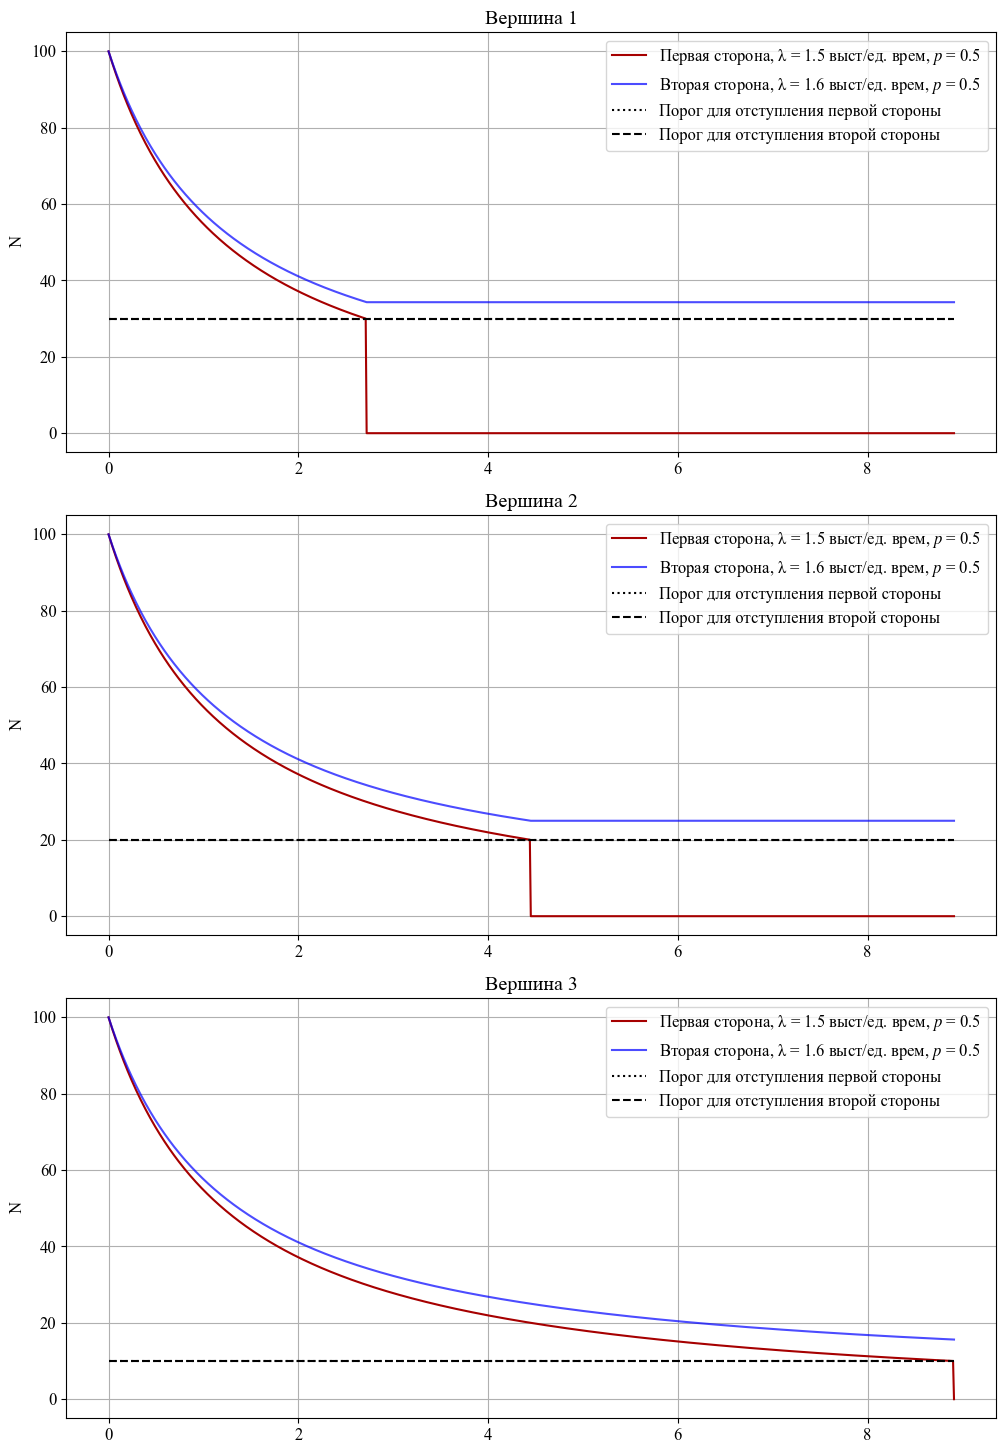

In [6]:
plt.figure(figsize=(12, len(Battle.nodes())*6))
subplots_adjust(hspace=0.15)

for v, node in enumerate(Battle.nodes()):
    ax1 = subplot(len(Battle.nodes()),1,v+1)
    ax1.set_title('{}'.format(node))
    ax1.plot(t_arr, Battle.nodes[node]['history_N_1'], 
             label='Первая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_1'], 
                                                                           Battle.nodes[node]['p_1']), 
             color='#A60000')
    ax1.plot(t_arr, Battle.nodes[node]['history_N_2'], 
             label='Вторая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_2'], 
                                                                           Battle.nodes[node]['p_2']), 
             color='blue', alpha=0.7)
    
    ax1.plot([t_arr[0], t_arr[-1]], [Battle.nodes[node]['N_for_retreat_1'], 
                                     Battle.nodes[node]['N_for_retreat_1']], 
             linestyle=':', color='black', label='Порог для отступления первой стороны')
    ax1.plot([t_arr[0], t_arr[-1]], [Battle.nodes[node]['N_for_retreat_2'], 
                                     Battle.nodes[node]['N_for_retreat_2']], 
             linestyle='--', color='black', label='Порог для отступления второй стороны')
    
    ax1.set_ylabel('N')
    ax1.grid()
    ax1.legend()

## Пример графа с произвольным кол-вом вершинами

In [7]:
# Прокликивать каждый раз с создания графа

In [8]:
# Создание графа
Battle = nx.Graph()

n = 9 # Количество вершин

# Задание параметров вершин с нормальным распределением
mean_lamda_1 = 1.5
std_lamda_1 = 0.3
mean_lamda_2 = 1.55
std_lamda_2 = 0.3

mean_p_1 = 0.6
std_p_1 = 0.1
mean_p_2 = 0.6
std_p_2 = 0.1

mean_N_10 = 100
std_N_10 = 15
mean_N_20 = 100
std_N_20 = 15

mean_casualties_lvl_1 = 0.3
std_casualties_lvl_1 = 0.05
mean_casualties_lvl_2 = 0.3
std_casualties_lvl_2 = 0.05

node_list = []
for i in range(n):
    node_list.append('Вершина {}'.format(i+1))
    Battle.add_node('Вершина {}'.format(i+1), 
                    lamda_1 = round(np.random.normal(mean_lamda_1, std_lamda_1, 1)[0], 2), 
                    lamda_2 = round(np.random.normal(mean_lamda_2, std_lamda_2, 1)[0], 2), 
                    p_1 = round(np.random.normal(mean_p_1, std_p_1, 1)[0], 2), 
                    p_2 = round(np.random.normal(mean_p_2, std_p_2, 1)[0], 2), 
                    N_10 = round(np.random.normal(mean_N_10, std_N_10, 1)[0], 2), 
                    N_20 = round(np.random.normal(mean_N_20, std_N_20, 1)[0], 2), 
                    casualties_lvl_1 = round(np.random.normal(mean_casualties_lvl_1, std_casualties_lvl_1, 1)[0], 2), 
                    casualties_lvl_2 = round(np.random.normal(mean_casualties_lvl_2, std_casualties_lvl_2, 1)[0], 2),
                    was_retreat = False)

for i in range(len(list(combinations(node_list, 2)))):
    Battle.add_edge(list(combinations(node_list, 2))[i][0], list(combinations(node_list, 2))[i][1], weight=np.random.randint(1,10)) 
   

for node in Battle.nodes():
    Battle.nodes[node]['N_1'] = Battle.nodes[node]['N_10']
    Battle.nodes[node]['N_2'] = Battle.nodes[node]['N_20']
    
    Battle.nodes[node]['N_for_retreat_1'] = Battle.nodes[node]['N_10'] * Battle.nodes[node]['casualties_lvl_1']
    Battle.nodes[node]['N_for_retreat_2'] = Battle.nodes[node]['N_20'] * Battle.nodes[node]['casualties_lvl_2']
    
    Battle.nodes[node]['a_1'] = Battle.nodes[node]['lamda_1'] * Battle.nodes[node]['p_1']
    Battle.nodes[node]['a_2'] = Battle.nodes[node]['lamda_2'] * Battle.nodes[node]['p_2']

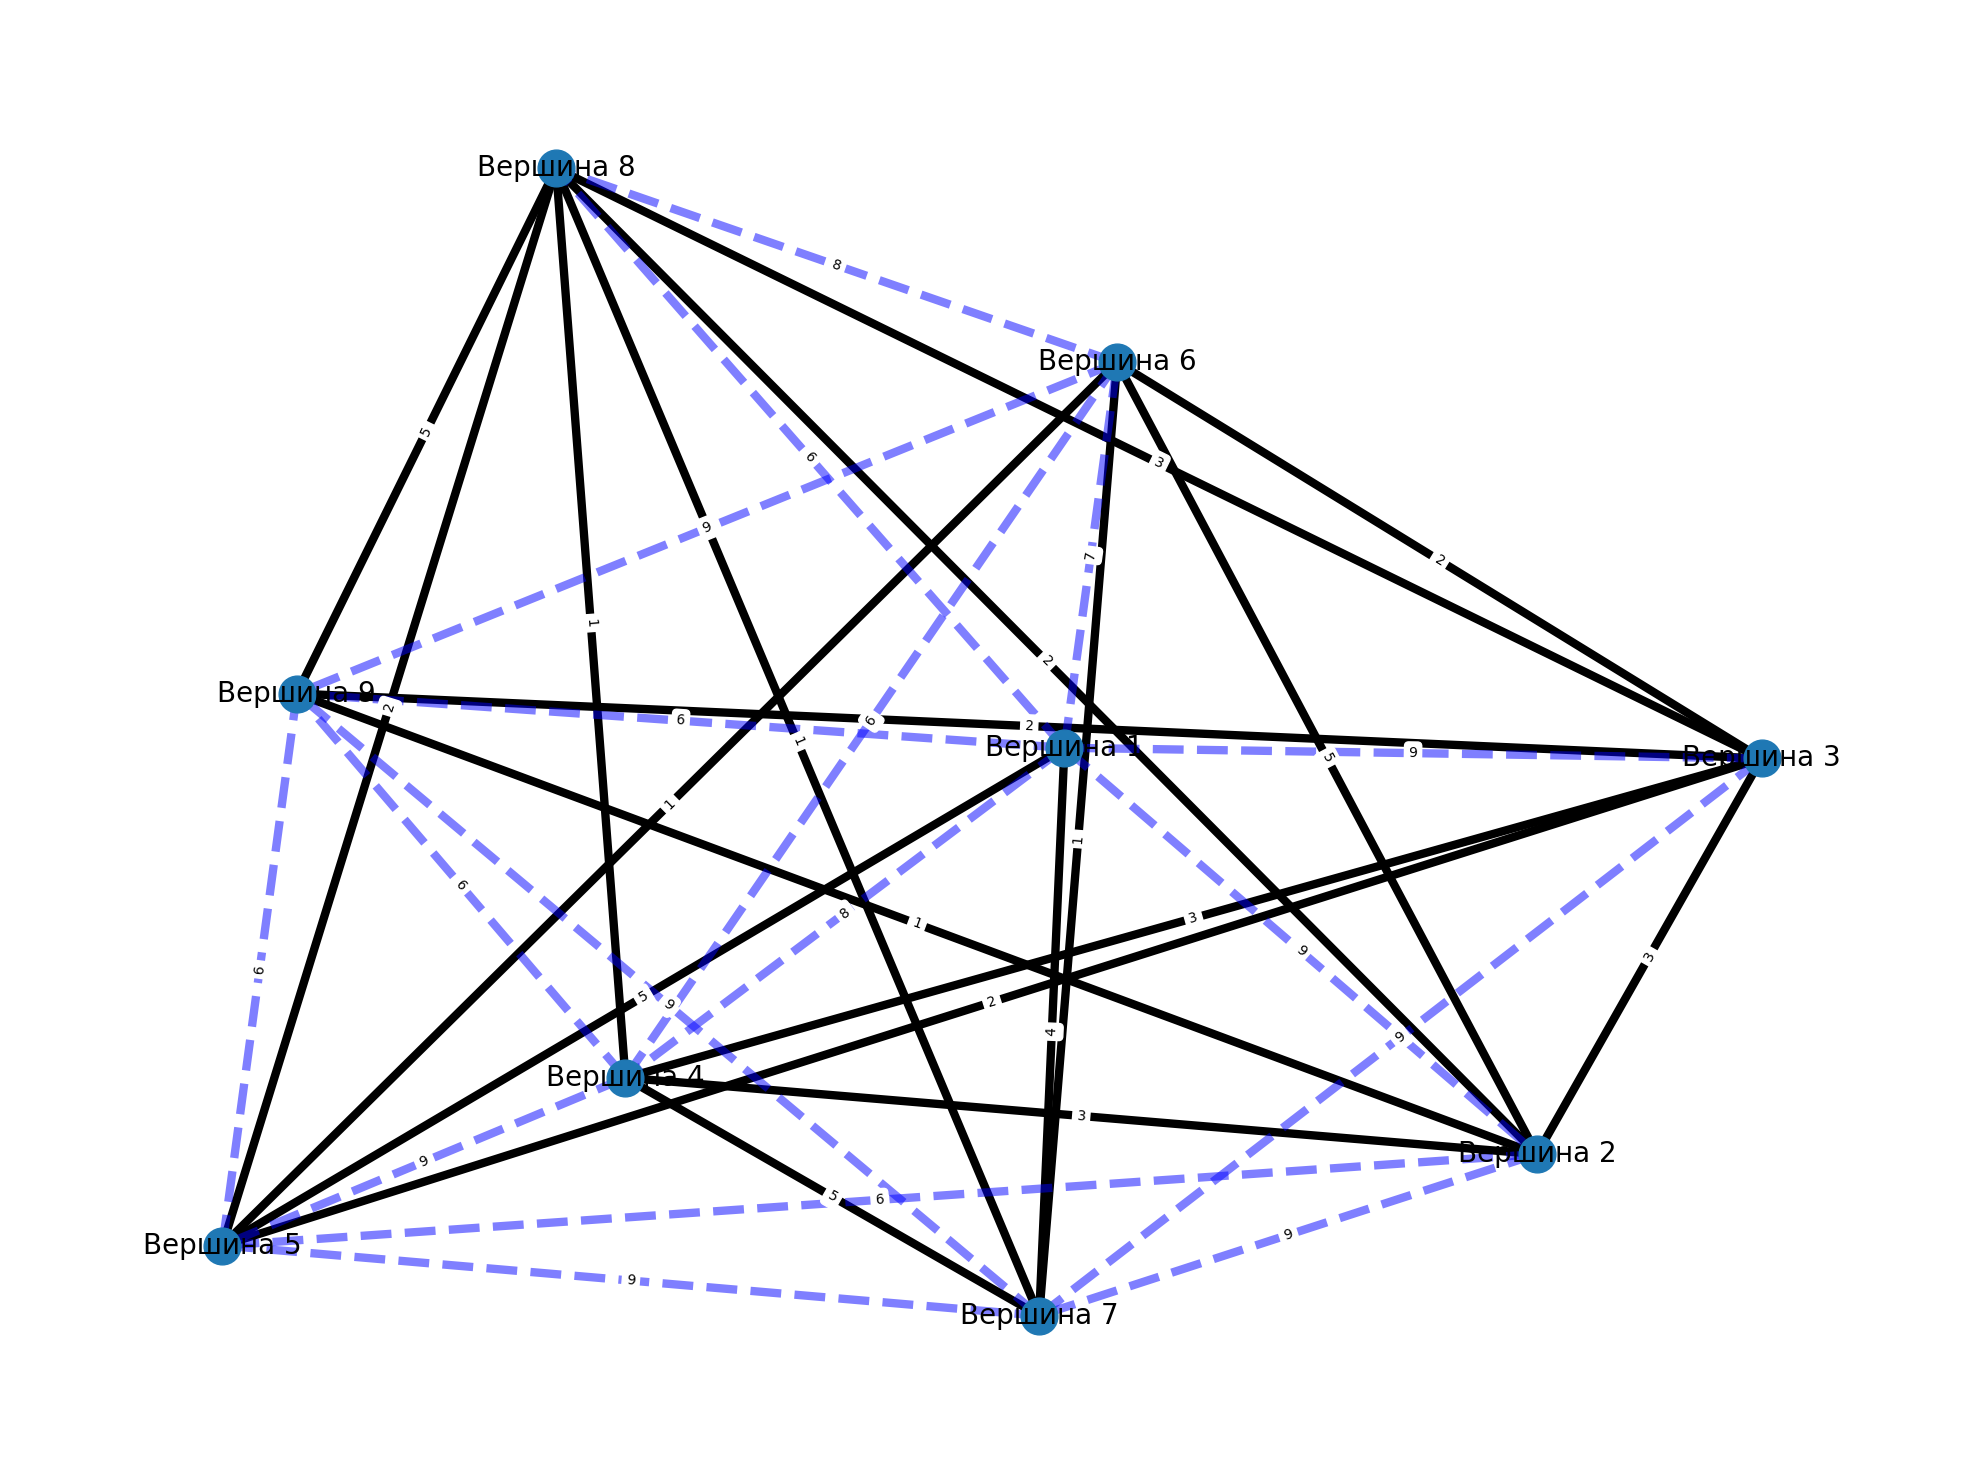

In [9]:
# Визуализация графа
plt.figure(figsize=(20,15))
elarge = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] <= 5]
esmall = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] > 5]

pos = nx.spring_layout(Battle, seed=7)

# nodes
nx.draw_networkx_nodes(Battle, pos, node_size=700)

# edges
nx.draw_networkx_edges(Battle, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    Battle, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(Battle, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(Battle, "weight")
nx.draw_networkx_edge_labels(Battle, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
t_of_simulation = 100
dt = 1e-2

tau = 0

for node in Battle.nodes():
    Battle.nodes[node]['history_N_1'] = [Battle.nodes[node]['N_1']]
    Battle.nodes[node]['history_N_2'] = [Battle.nodes[node]['N_2']]
    
t_arr = np.array([tau])

list_of_reinforces = []
while (tau <= t_of_simulation) and (sum(list(nx.get_node_attributes(Battle, 'N_1').values())) > 0) and (sum(list(nx.get_node_attributes(Battle, 'N_2').values())) > 0):
    tau += dt
    tau = round(tau,2)
    for node in Battle.nodes():
        # Функция управления
        if Battle.nodes[node]['N_1'] == 0 and Battle.nodes[node]['was_retreat'] == False:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_2'] += Battle.nodes[node]['N_2'] 
                Battle.nodes[node]['a_2'] = (Battle.nodes[node]['a_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['a_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                Battle.nodes[node]['N_for_retreat_2'] = (Battle.nodes[node]['N_for_retreat_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['N_for_retreat_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                Battle.nodes[node]['N_2'] = 0
                Battle.nodes[node]['was_retreat'] = True
                list_of_reinforces.append([tau, node, closest_node, 'Сторона 2'])
        
        if Battle.nodes[node]['N_2'] == 0 and Battle.nodes[node]['was_retreat'] == False:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_1'] += Battle.nodes[node]['N_1']
                Battle.nodes[node]['a_1'] = (Battle.nodes[node]['a_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['a_1']*Battle.nodes[closest_node]['N_1'])/(Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
                Battle.nodes[node]['N_for_retreat_1'] = (Battle.nodes[node]['N_for_retreat_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['N_for_retreat_1']*Battle.nodes[closest_node]['N_1'])/(Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
                Battle.nodes[node]['N_1'] = 0
                Battle.nodes[node]['was_retreat'] = True
                list_of_reinforces.append([tau, node, closest_node, 'Сторона 1'])

        # Изменение численности войск
        dN_1 = -Battle.nodes[node]['a_2'] * Battle.nodes[node]['N_2'] * Battle.nodes[node]['N_1']/Battle.nodes[node]['N_10'] * dt
        dN_2 = -Battle.nodes[node]['a_1'] * Battle.nodes[node]['N_1'] * Battle.nodes[node]['N_2']/Battle.nodes[node]['N_20'] * dt                            
        Battle.nodes[node]['N_1'] += dN_1
        Battle.nodes[node]['N_2'] += dN_2

        # Проверка было ли отступление
        if Battle.nodes[node]['N_1'] < Battle.nodes[node]['N_for_retreat_1']:
            Battle.nodes[node]['N_1'] = 0
        if Battle.nodes[node]['N_2'] < Battle.nodes[node]['N_for_retreat_2']:
            Battle.nodes[node]['N_2'] = 0     
        
        Battle.nodes[node]['history_N_1'].append(Battle.nodes[node]['N_1'])
        Battle.nodes[node]['history_N_2'].append(Battle.nodes[node]['N_2'])
    t_arr = np.append(t_arr, tau)

Список подкреплений, время //из какой вершины//в какую вершину//сторона перебрасывающая подкрепления

In [14]:
if sum(list(nx.get_node_attributes(Battle, 'N_1').values())) > sum(list(nx.get_node_attributes(Battle, 'N_2').values())):
    print('Победа 1й стороны')
else:
    print('Победа 2й стороны')

Победа 2й стороны


In [11]:
list_of_reinforces

[[0.74, 'Вершина 4', 'Вершина 8', 'Сторона 1'],
 [1.07, 'Вершина 1', 'Вершина 7', 'Сторона 2'],
 [1.13, 'Вершина 5', 'Вершина 6', 'Сторона 2'],
 [1.21, 'Вершина 3', 'Вершина 6', 'Сторона 2'],
 [1.22, 'Вершина 7', 'Вершина 6', 'Сторона 2'],
 [1.33, 'Вершина 6', 'Вершина 2', 'Сторона 2'],
 [1.49, 'Вершина 8', 'Вершина 2', 'Сторона 1'],
 [2.87, 'Вершина 9', 'Вершина 2', 'Сторона 2']]

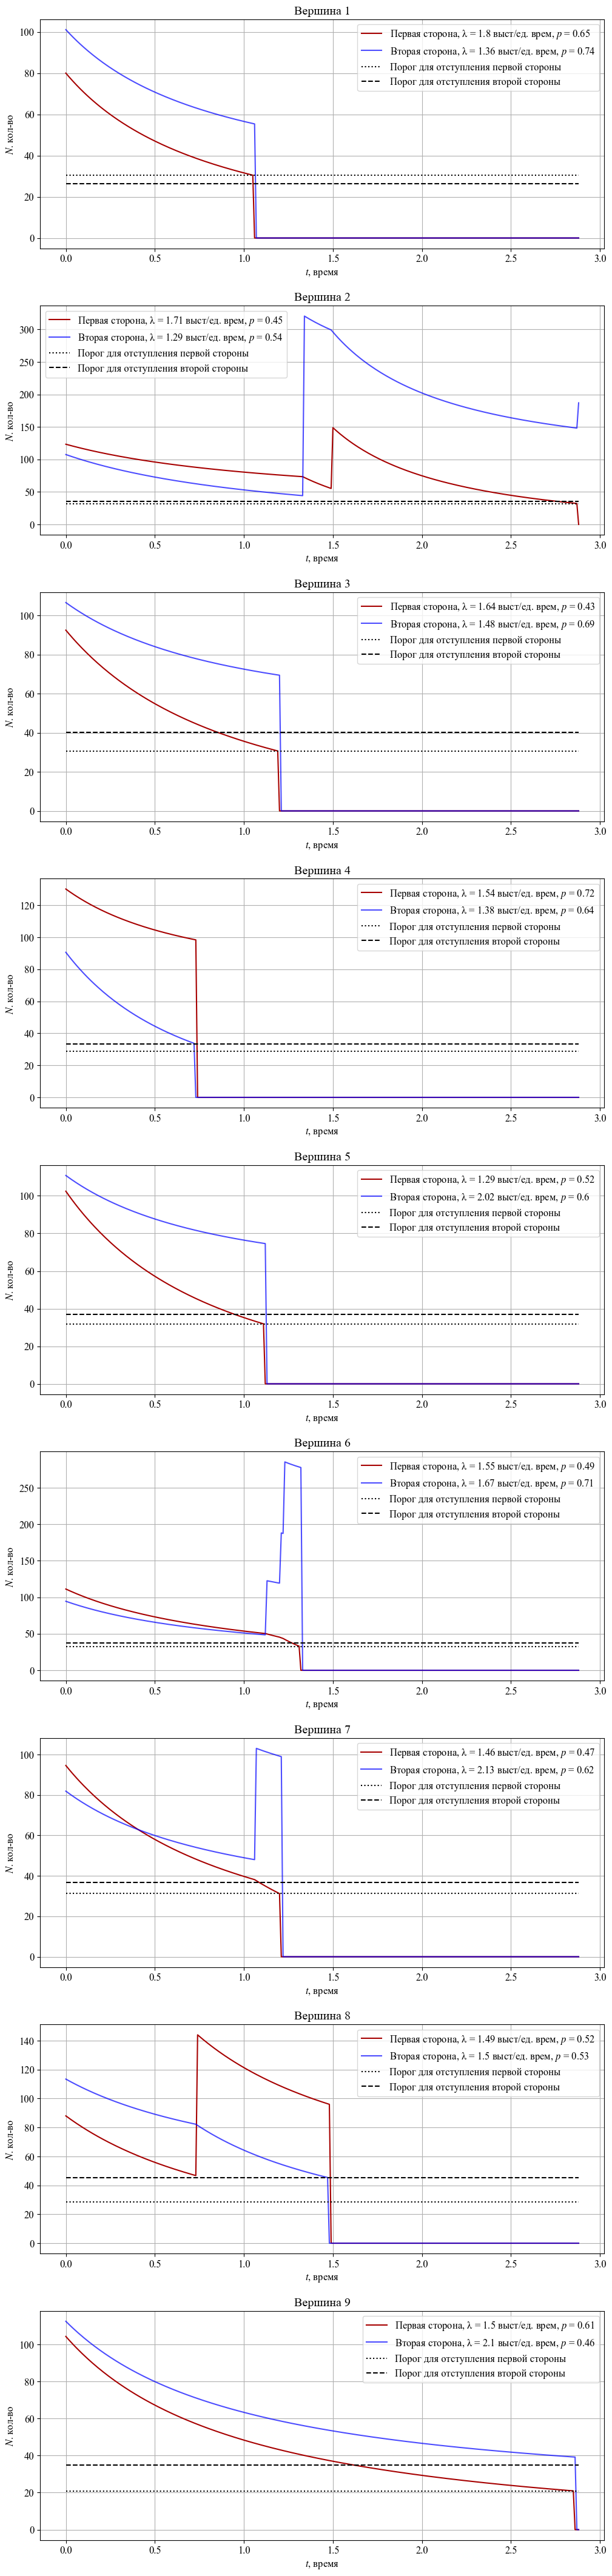

In [17]:
plt.figure(figsize=(12, len(Battle.nodes())*6))
subplots_adjust(hspace=0.25)

for v, node in enumerate(Battle.nodes()):
    ax1 = subplot(len(Battle.nodes()),1,v+1)
    ax1.set_title('{}'.format(node))
    ax1.plot(t_arr, Battle.nodes[node]['history_N_1'], 
             label='Первая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_1'], 
                                                                           Battle.nodes[node]['p_1']), 
             color='#A60000')
    ax1.plot(t_arr, Battle.nodes[node]['history_N_2'], 
             label='Вторая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_2'], 
                                                                           Battle.nodes[node]['p_2']), 
             color='blue', alpha=0.7)
    
    ax1.plot([t_arr[0], t_arr[-1]], [Battle.nodes[node]['N_for_retreat_1'], 
                                     Battle.nodes[node]['N_for_retreat_1']], 
             linestyle=':', color='black', label='Порог для отступления первой стороны')
    ax1.plot([t_arr[0], t_arr[-1]], [Battle.nodes[node]['N_for_retreat_2'], 
                                     Battle.nodes[node]['N_for_retreat_2']], 
             linestyle='--', color='black', label='Порог для отступления второй стороны')
    
    ax1.set_ylabel('$N$. кол-во')
    ax1.set_xlabel('$t$, время')
    ax1.grid()
    ax1.legend()

In [13]:
import networkx as nx

# Создание графа
G = nx.Graph()

# Добавление вершин и ребер с весами
G.add_edge(1, 2, weight=10)  # Ребро между вершинами 1 и 2 с весом 10
G.add_edge(2, 3, weight=5)  # Ребро между вершинами 2 и 3 с весом 5

# Начальная и конечная вершины
start_node = 1
end_node = 3

# Вызов функции Дейкстры для нахождения пути с учетом весов ребер
path = nx.dijkstra_path(G, start_node, end_node, weight='weight')
total_time = nx.dijkstra_path_length(G, start_node, end_node, weight='weight')

print(f"Оптимальный путь: {path}")
print(f"Общее время: {total_time}")

Оптимальный путь: [1, 2, 3]
Общее время: 15
